In [38]:
# Importing data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC


from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import warnings

# Suppress specific warning
warnings.filterwarnings("ignore", category=UserWarning, module="keras")

In [2]:
# Loading three CSV files into pandas DataFrames
injury_data = pd.read_csv('InjuryRecord.csv')
play_data = pd.read_csv('PlayList.csv')
track_data = pd.read_csv('PlayerTrackData.csv')

In [3]:
# Merging Datasets: 
combined_data = pd.merge(play_data, track_data, on=['PlayKey'], how='inner')

# Adding a new column indicating whether or not an injury occured
combined_data['InjuryOccurred'] = combined_data['PlayKey'].isin(injury_data['PlayKey']).astype(int)

# Ensuring there is no NA data
combined_data = combined_data.dropna()

# Step 1: Split the data based on injury occurrence
injury_occurred = combined_data[combined_data['InjuryOccurred'] == 1]
no_injury_occurred = combined_data[combined_data['InjuryOccurred'] == 0]

no_injury_occurred = no_injury_occurred.dropna()

# Step 2: Sample data
# Take 100 rows where injury occurred
injury_sample = injury_occurred.sample(n=100, random_state=42)
# Take 100 rows where no injury occurred
no_injury_sample = no_injury_occurred.sample(n=100, random_state=42)

# Step 3: Combine the samples
final_sample = pd.concat([injury_sample, no_injury_sample])

# Step 4: Shuffle the final dataset to randomize the order
random_sampled_data = final_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
# Feature Engineering

# 1. Adding feature indicating if player had prior injuries
random_sampled_data['PriorInjuries'] = random_sampled_data.groupby('PlayerKey')['InjuryOccurred'].cumsum().shift(fill_value=0)

# 2. Adding features for various weathers
# One-hot encoding for Weather data
weather_encoded = pd.get_dummies(random_sampled_data['Weather'], prefix='Weather')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, weather_encoded], axis=1)
# Drop the original 'Weather' column if no longer needed
random_sampled_data.drop(columns=['Weather'], inplace=True)
# Group definitions for weather categories
weather_groups = {
    'Sunny_Weather': [
        'Weather_Sunny', 'Weather_Sunny Skies', 'Weather_Sunny and clear',
        'Weather_Sunny and cold', 'Weather_Sunny and warm', 'Weather_Mostly sunny', 
        'Weather_Partly Sunny', 'Weather_Partly sunny', 
        'Weather_Sunny, Windy', 'Weather_Sunny, highs to upper 80s',  'Weather_Mostly Sunny', 'Weather_Mostly Sunny Skies'
    ],
    'Clear_Weather': [
        'Weather_Clear',
        'Weather_Clear Skies', 'Weather_Clear and Cool',
        'Weather_Clear and Sunny', 'Weather_Clear and cold',
        'Weather_Clear and sunny', 'Weather_Clear and warm',
        'Weather_Clear skies', 'Weather_Clear to Partly Cloudy', 'Weather_Partly clear'
    ],
    'Cloudy_Weather': [
        'Weather_Cloudy', 'Weather_Cloudy and Cool', 'Weather_Cloudy and cold',
        'Weather_Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Weather_Cloudy, 50% change of rain', 'Weather_Cloudy, Rain',
        'Weather_Cloudy, chance of rain', 'Weather_cloudy', 'Weather_Overcast', 
        'Weather_Cloudy, fog started developing in 2nd quarter',
        'Weather_Cloudy, light snow accumulating 1-3"', 'Weather_Coudy',
        'Weather_Mostly Cloudy', 'Weather_Mostly Coudy', 'Weather_Mostly cloudy'
    ],
    'Low_Rain_Weather': [
        'Weather_10% Chance of Rain', 'Weather_30% Chance of Rain', 'Weather_Light Rain'
    ],
    'Rainy_Weather': [
        'Weather_Rain', 'Weather_Rain Chance 40%', 'Weather_Rain likely, temps in low 40s.',
        'Weather_Rain shower', 'Weather_Rainy', 'Weather_Scattered Showers',
        'Weather_Showers'
    ],
    'Indoor_Weather': [
        'Weather_Indoor', 'Weather_Indoors', 'Weather_Controlled Climate',
        'Weather_N/A (Indoors)', 'Weather_N/A Indoor'
    ],
    'Partly_Cloudy_Weather': [
        'Weather_Partly Cloudy', 'Weather_Partly Clouidy', 'Weather_Partly cloudy',
        'Weather_Party Cloudy', 'Weather_Sun & clouds'
    ],
    'Snowy_Weather': [
        'Weather_Snow', 'Weather_Heavy lake effect snow'
    ],
    'Other_Weather': [
        'Weather_Fair', 'Weather_Hazy', 'Weather_Heat Index 95'
    ]
}
for group_name, columns in weather_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

# 3. Adding features for various field types
field_type_encoded = pd.get_dummies(random_sampled_data['FieldType'], prefix='FieldType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, field_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['FieldType'], inplace=True)

# 4. Adding features for various stadium types
stadium_type_encoded = pd.get_dummies(random_sampled_data['StadiumType'], prefix='StadiumType')
# Combine the encoded columns with the original DataFrame
random_sampled_data = pd.concat([random_sampled_data, stadium_type_encoded], axis=1)
# Drop the original 'FieldType' column if no longer needed
random_sampled_data.drop(columns=['StadiumType'], inplace=True)
stadium_type_groups = {
    'Indoor_Stadium': [
        'StadiumType_Closed Dome', 'StadiumType_Dome', 'StadiumType_Dome, closed',
        'StadiumType_Domed', 'StadiumType_Indoor', 'StadiumType_Indoor, Open Roof',
        'StadiumType_Indoor, Roof Closed', 'StadiumType_Indoors'
    ],
    'Outdoor_Stadium': [
        'StadiumType_Bowl', 'StadiumType_Cloudy', 'StadiumType_Heinz Field',
        'StadiumType_Open', 'StadiumType_Oudoor', 'StadiumType_Ourdoor',
        'StadiumType_Outddors', 'StadiumType_Outdoor', 'StadiumType_Outdoors',
        'StadiumType_Outdor', 'StadiumType_Outside'
    ],
    'Retractable_Roof_Stadium': [
        'StadiumType_Domed, Open', 'StadiumType_Domed, open',
        'StadiumType_Outdoor Retr Roof-Open', 'StadiumType_Retr. Roof - Closed',
        'StadiumType_Retr. Roof - Open', 'StadiumType_Retr. Roof Closed', 'StadiumType_Domed, closed',
        'StadiumType_Retr. Roof-Closed', 'StadiumType_Retractable Roof', 'StadiumType_Retr. Roof-Open'
    ]
}
# Iterate through stadium type groups and combine columns
for group_name, columns in stadium_type_groups.items():
    # Check if the columns exist in the DataFrame
    columns_present = [col for col in columns if col in random_sampled_data.columns]
    # Combine the columns
    random_sampled_data[group_name] = random_sampled_data[columns_present].max(axis=1)
    # Optionally drop the old columns
    random_sampled_data.drop(columns=columns_present, inplace=True)

random_sampled_data['WeekOfSeason'] = (random_sampled_data['PlayerDay'] // 7) + 1

columns_of_interest  = [
    'Sunny_Weather', 'Clear_Weather', 'Cloudy_Weather', 'Low_Rain_Weather', 
    'Rainy_Weather', 'Indoor_Weather', 'Partly_Cloudy_Weather', 'Snowy_Weather', 
    'Other_Weather', 'FieldType_Natural', 'FieldType_Synthetic', 'Indoor_Stadium', 
    'Outdoor_Stadium', 'Retractable_Roof_Stadium', 'Weather_Cold', 'PriorInjuries', 'Temperature', 'WeekOfSeason']

for column in columns_of_interest:
    random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})


/var/folders/1v/rphybfn151d42hnnhv4s72jm0000gn/T/ipykernel_85414/3216886262.py:118: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  random_sampled_data[column] = random_sampled_data[column].replace({True: 1, False: 0})


In [5]:

# Filter the DataFrame to use only the columns of interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]  # Add 'InjuryOccurred' as target column

print(df_of_interest[columns_of_interest].info())
print(df_of_interest['InjuryOccurred'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Sunny_Weather             200 non-null    int64  
 1   Clear_Weather             200 non-null    int64  
 2   Cloudy_Weather            200 non-null    int64  
 3   Low_Rain_Weather          200 non-null    int64  
 4   Rainy_Weather             200 non-null    int64  
 5   Indoor_Weather            200 non-null    int64  
 6   Partly_Cloudy_Weather     200 non-null    int64  
 7   Snowy_Weather             0 non-null      float64
 8   Other_Weather             0 non-null      float64
 9   FieldType_Natural         200 non-null    int64  
 10  FieldType_Synthetic       200 non-null    int64  
 11  Indoor_Stadium            200 non-null    int64  
 12  Outdoor_Stadium           200 non-null    int64  
 13  Retractable_Roof_Stadium  200 non-null    int64  
 14  Weather_Co

In [6]:

# Removing Snowy_Weather and Other_Weather columns as they are null
random_sampled_data = random_sampled_data.drop(columns=['Snowy_Weather', 'Other_Weather'])
columns_of_interest  = [
    'Sunny_Weather', 'Clear_Weather', 'Cloudy_Weather', 'Low_Rain_Weather', 
    'Rainy_Weather', 'Indoor_Weather', 'Partly_Cloudy_Weather',  'FieldType_Natural', 
    'FieldType_Synthetic', 'Indoor_Stadium', 'Outdoor_Stadium', 'Retractable_Roof_Stadium', 
    'Weather_Cold', 'PriorInjuries', 'Temperature', 'WeekOfSeason']

print(df_of_interest[columns_of_interest].info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   Sunny_Weather             200 non-null    int64
 1   Clear_Weather             200 non-null    int64
 2   Cloudy_Weather            200 non-null    int64
 3   Low_Rain_Weather          200 non-null    int64
 4   Rainy_Weather             200 non-null    int64
 5   Indoor_Weather            200 non-null    int64
 6   Partly_Cloudy_Weather     200 non-null    int64
 7   FieldType_Natural         200 non-null    int64
 8   FieldType_Synthetic       200 non-null    int64
 9   Indoor_Stadium            200 non-null    int64
 10  Outdoor_Stadium           200 non-null    int64
 11  Retractable_Roof_Stadium  200 non-null    int64
 12  Weather_Cold              200 non-null    int64
 13  PriorInjuries             200 non-null    int64
 14  Temperature               200 non-null    

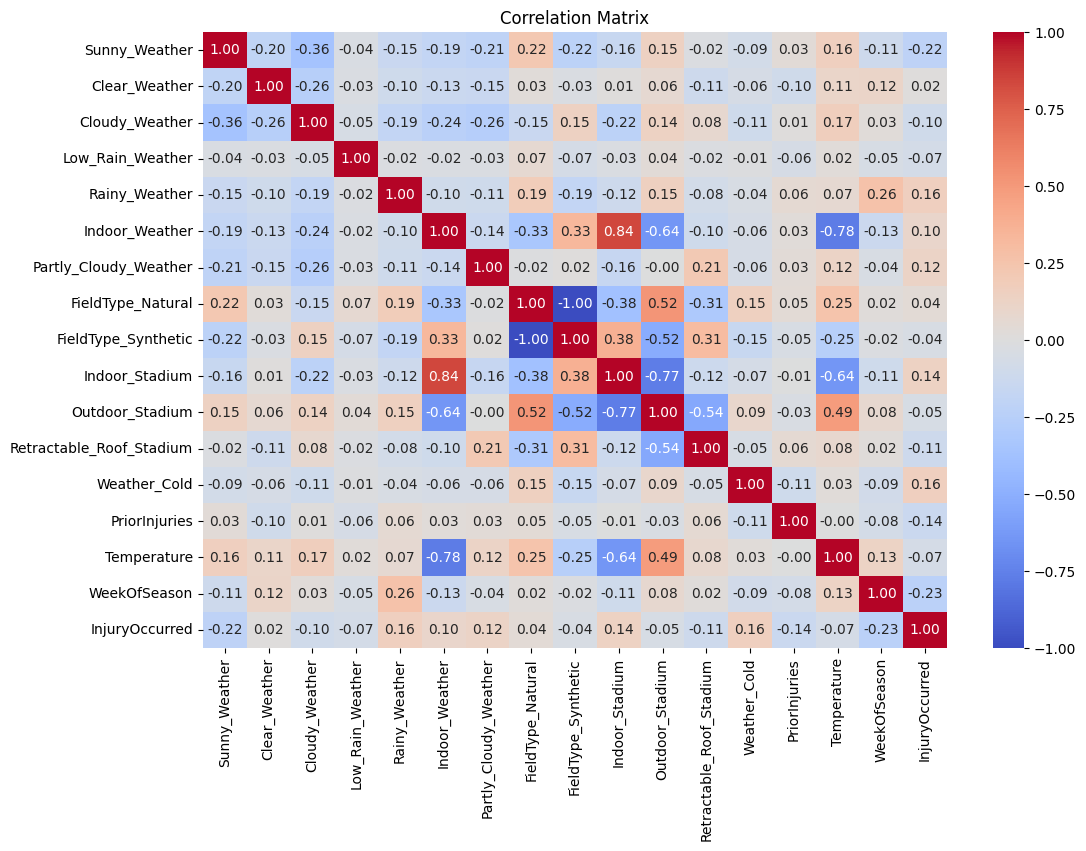

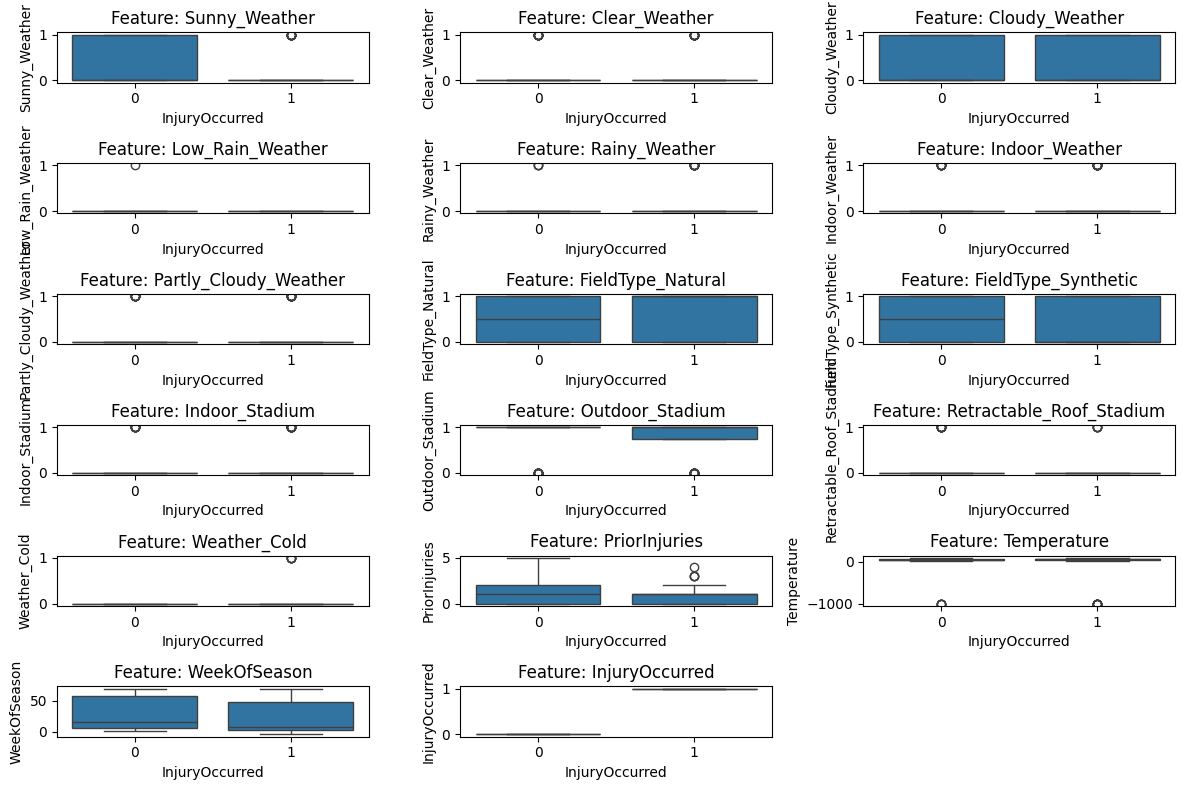

In [7]:
# Separate numerical and categorical columns from columns_of_interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]

numerical_features = df_of_interest.select_dtypes(include=['float64', 'int64'])  # Numerical columns
categorical_features = df_of_interest.select_dtypes(include=['object', 'category'])  # Categorical columns

# Correlation Matrix for Numerical Features
if not numerical_features.empty:  # Ensure there are numerical features to plot
    correlation_matrix = numerical_features.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

# Box Plots for Numerical Features vs Injury Occurrence
if not numerical_features.empty:  # Ensure there are numerical features to plot
    plt.figure(figsize=(12, 8))
    num_plots = len(numerical_features.columns)
    rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

    for i, col in enumerate(numerical_features.columns):
        plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
        sns.boxplot(x='InjuryOccurred', y=col, data=df_of_interest)
        plt.title(f'Feature: {col}')
    
    plt.tight_layout()
    plt.show()

# Bar Plots for Categorical Features vs Injury Occurrence
if not categorical_features.empty:  # Ensure there are categorical features to plot
    plt.figure(figsize=(12, 8))
    num_plots = len(categorical_features.columns)
    rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

    for i, col in enumerate(categorical_features.columns):
        plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
        sns.countplot(x=col, hue='InjuryOccurred', data=df_of_interest, palette='pastel')
        plt.title(f'Feature: {col}')
        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    
    plt.tight_layout()
    plt.show()


In [19]:
# Update columns of interest
columns_of_interest = [ 'Sunny_Weather', 'Outdoor_Stadium', 'Temperature', 'FieldType_Natural',
                       'WeekOfSeason', 'PriorInjuries', 'Indoor_Stadium', 'Indoor_Weather']


X = random_sampled_data[columns_of_interest].fillna(0)
y = random_sampled_data['InjuryOccurred'].fillna(0)

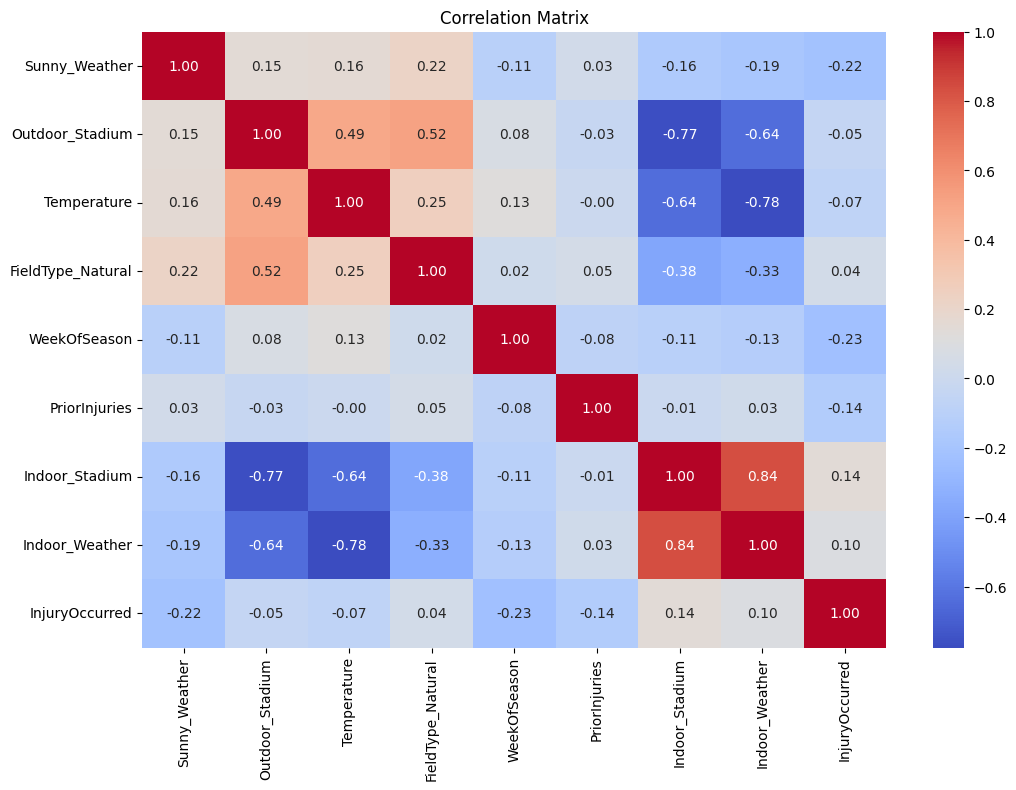

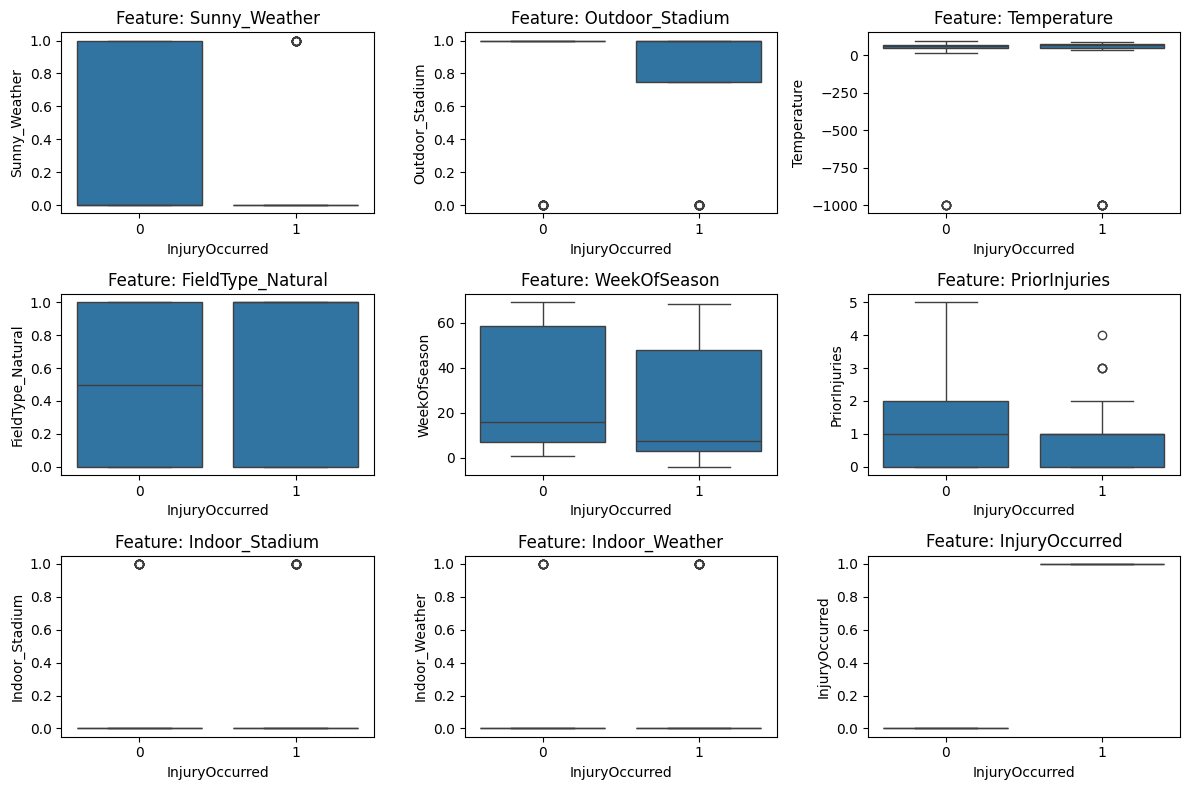

<Figure size 1200x800 with 0 Axes>

In [20]:
# Filter the DataFrame to use only the columns of interest
df_of_interest = random_sampled_data[columns_of_interest + ['InjuryOccurred']]  # Add 'InjuryOccurred' as target column

# Separate numerical and categorical columns from columns_of_interest
numerical_features = df_of_interest.select_dtypes(include=['float64', 'int64'])  # Numerical columns
categorical_features = df_of_interest.select_dtypes(include=['object'])  # Categorical columns

# Correlation Matrix for Numerical Features
correlation_matrix = numerical_features.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Box Plots for Numerical Features vs Injury Occurrence
plt.figure(figsize=(12, 8))
num_plots = len(numerical_features.columns)
rows = (num_plots // 3) + (1 if num_plots % 3 != 0 else 0)  # Calculate number of rows needed

for i, col in enumerate(numerical_features.columns):
    plt.subplot(rows, 3, i + 1)  # Adjust rows and columns dynamically
    sns.boxplot(x='InjuryOccurred', y=col, data=df_of_interest)
    plt.title(f'Feature: {col}')
    
plt.tight_layout()
plt.show()

# Bar Plots for Categorical Features vs Injury Occurrence
plt.figure(figsize=(12, 8))
for i, col in enumerate(categorical_features.columns):
    plt.subplot(2, 3, i + 1)
    sns.countplot(x=col, hue='InjuryOccurred', data=df_of_interest)
    plt.title(f'Feature: {col}')
    
plt.tight_layout()
plt.show()


In [21]:
# Populating Training and Testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For Random Forest Classifier               precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.79      0.86      0.83        22

    accuracy                           0.80        40
   macro avg       0.80      0.79      0.80        40
weighted avg       0.80      0.80      0.80        40



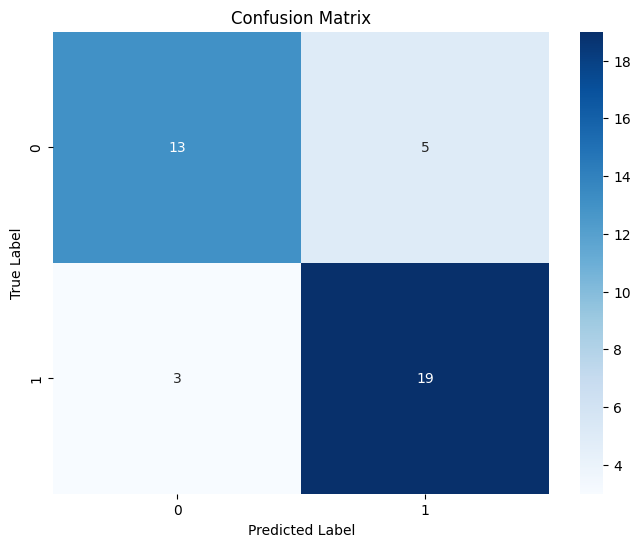

In [22]:
# Creating model for Random Forest

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("For Random Forest Classifier",classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.61      0.78      0.68        18
           1       0.76      0.59      0.67        22

    accuracy                           0.68        40
   macro avg       0.69      0.68      0.67        40
weighted avg       0.69      0.68      0.67        40



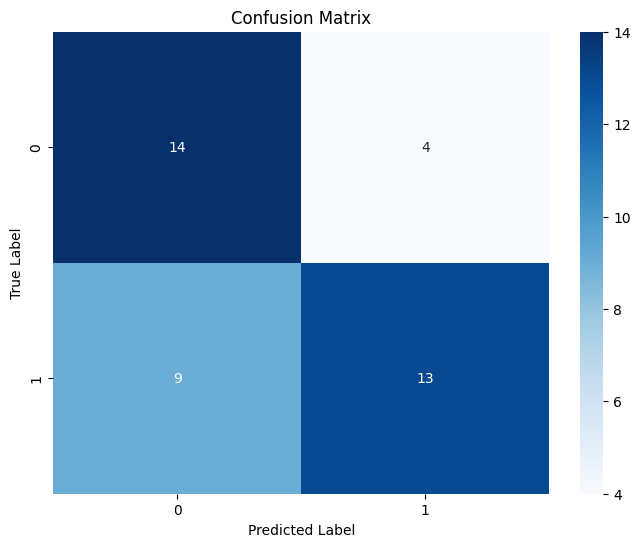

In [35]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

              precision    recall  f1-score   support

           0       0.53      0.50      0.51        18
           1       0.61      0.64      0.62        22

    accuracy                           0.57        40
   macro avg       0.57      0.57      0.57        40
weighted avg       0.57      0.57      0.57        40



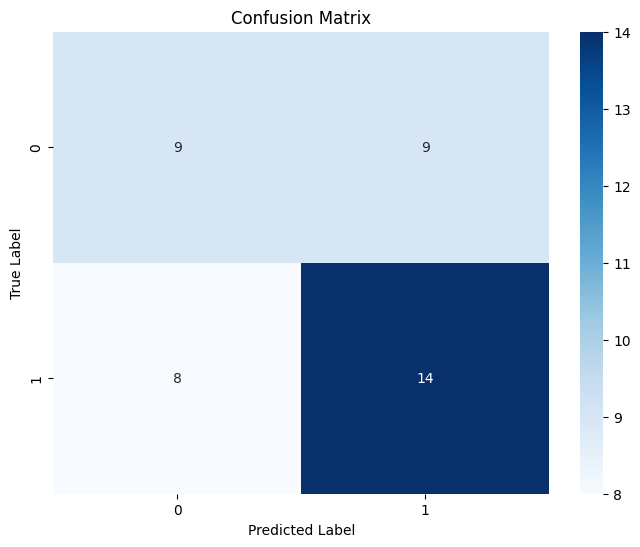

In [36]:
svm_model = SVC(kernel='rbf', random_state=42, max_iter=10000)  # Radial basis function kernel is commonly used for non-linear classification
svm_model.fit(X_train, y_train)
predictions = svm_model.predict(X_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
def build_model(num_layers, neurons, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_dim=X_train.shape[1]))
    for _ in range(num_layers):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Hyperparameter tuning
num_layers = 9
neurons = 64
dropout_rate = 0.2
learning_rate = 0.001
batch_size = 32

# Build and train the model
model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce learning rate by this factor
    patience=3,          # Wait 3 epochs before reducing
    min_lr=1e-5          # Minimum learning rate
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test loss: {test_loss:.2f}")


# Print the accuracy scores for each fold and the average 

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.4406 - loss: 1.3901 - val_accuracy: 0.3750 - val_loss: 0.7213 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5042 - loss: 0.9382 - val_accuracy: 0.3750 - val_loss: 0.7781 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4448 - loss: 0.8258 - val_accuracy: 0.3750 - val_loss: 0.7495 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4823 - loss: 0.7948 - val_accuracy: 0.3750 - val_loss: 0.7162 - learning_rate: 0.0010
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5469 - loss: 0.7858 - val_accuracy: 0.3750 - val_loss: 0.7191 - learning_rate: 0.0010
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5177 - loss: 0.8588 - val_accuracy: 0.3750 - val_loss: 0.7166 - learning_rate: 0.0010
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4885 - loss: 0.8622 - val_accuracy: 0.3750 - val_

In [40]:

param_grid = {
    'num_layers': [3, 5, 7, 9, 11],
    'neurons': [64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001],
    'batch_size': [32, 64, 72, 128]
}

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Initialize best metrics
best_accuracy = 0
best_loss = 2
best_params = {}
best_score = 0

# Split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iterate over all combinations of hyperparameters
for num_layers in param_grid['num_layers']:
    for neurons in param_grid['neurons']:
        for dropout_rate in param_grid['dropout_rate']:
            for learning_rate in param_grid['learning_rate']:
                for batch_size in param_grid['batch_size']:
                    # Build and train the model
                    model = build_model(num_layers=num_layers, neurons=neurons, dropout_rate=dropout_rate, learning_rate=learning_rate)
                    
                    # Train the model with the current hyperparameters
                    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=batch_size, callbacks=[reduce_lr, early_stopping])

                    
                    # Evaluate the model
                    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
                    if test_loss < 0.7 and test_accuracy> 0.5:
                        print(f"Evaluating model with params: num_layers={num_layers}, neurons={neurons}, "
                            f"dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")
                        print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")
                    
                    score = test_accuracy - (test_loss * 0.5)  # You can adjust the weight factor
                    # Update the best parameters based on the score
                    if score > best_score:
                        best_score = score
                        best_accuracy = test_accuracy
                        best_loss = test_loss
                        best_params = {
                            'num_layers': num_layers,
                            'neurons': neurons,
                            'dropout_rate': dropout_rate,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size
                        }

# Output the best combination of hyperparameters
print("\nBest Model Parameters:")
print(f"Test Accuracy: {best_accuracy:.2f}")
print(f"Test Loss: {best_loss:.2f}")
print(f"Best Hyperparameters: {best_params}")

Epoch 1/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4927 - loss: 3.0497 - val_accuracy: 0.5000 - val_loss: 2.0271 - learning_rate: 0.0010
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4812 - loss: 2.6385 - val_accuracy: 0.5000 - val_loss: 1.8973 - learning_rate: 0.0010
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4906 - loss: 2.8146 - val_accuracy: 0.6250 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5031 - loss: 2.2925 - val_accuracy: 0.5000 - val_loss: 1.2798 - learning_rate: 0.0010
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4719 - loss: 1.8879 - val_accuracy: 0.5312 - val_loss: 1.4336 - learning_rate: 0.0010
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5344 - loss: 2.5222 - val_accuracy: 0.5000 - val_loss: 1.5433 - learning_rate: 0.0010
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5531 - loss: 2.5460 - val_accuracy: 0.5312 - val_

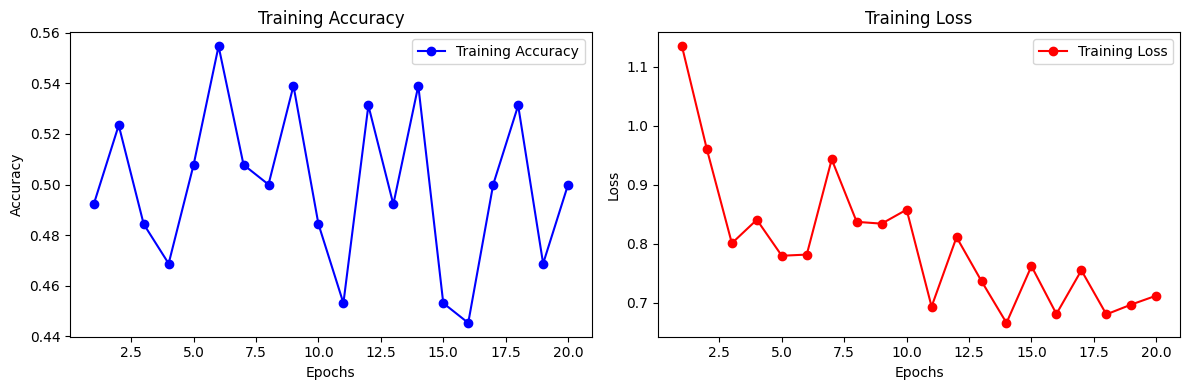

In [43]:
# Extract accuracy and loss values
accuracy_values = history.history['accuracy']
loss_values = history.history['loss']

def plot_training_history(accuracy_values, loss_values):
    """Plots the training accuracy and loss curves."""

    epochs = range(1, len(accuracy_values) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy_values, 'bo-', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss_values, 'ro-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_training_history(accuracy_values, loss_values)